# Package installation

Checking if there are any available devices.

In [ ]:
import jax
import jax.numpy as jnp

In [ ]:
jax.local_device_count()

1

In [ ]:
jax.devices()

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]

Cloning project repository.

In [ ]:
!git clone https://github.com/R3purg/Text2Image-DALL-E.git

Cloning into 'Text2Image-DALL-E'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 15 (delta 1), reused 11 (delta 1), pack-reused 0
Unpacking objects: 100% (15/15), done.


CD into project folder.

In [ ]:
%cd Text2Image-DALL-E

/content/Text2Image-DALL-E


Installing the DALLE-Mini model.

In [ ]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Downloading files to local folder

Importing packages from DALLE-Mini, VQGAN-JAX and CLIP models. The models that will be used in the whole process of Text2Image.

In [ ]:
import sys
if '/content/Text2Image-DALL-E/dalle-mini/vqgan/vqgan_jax' not in sys.path:
  sys.path.append('/content/Text2Image-DALL-E/dalle-mini/vqgan/vqgan_jax')
print(sys.path)

['/content', '/env/python', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.8/dist-packages/IPython/extensions', '/root/.ipython', '/content/Text2Image-DALL-E/dalle-mini/vqgan/vqgan_jax', '/tmp/tmp_z__ize7']


In [ ]:
# from transformers.generation_flax_utils import FlaxSampleOutput -> from transformers.generation.flax_utils import FlaxSampleOutput
from dalle_mini import DalleBart, DalleBartProcessor
from modeling_flax_vqgan import VQModel
from transformers import CLIPProcessor, FlaxCLIPModel

We will use huggingface python library, so we import it.

In [ ]:
from huggingface_hub import hf_hub_url, cached_download, hf_hub_download

Downloading models DALLE-Mini and VQGAN separately. Downloading in the **content** folder. We download all the local files from huggingface repository.
The 8 files to be downloaded from DALLE-Mini repository.

In [ ]:
dalle_mini_files_list = ['config.json', 'tokenizer.json', 
             'tokenizer_config.json', 'merges.txt', 'vocab.json', 
             'special_tokens_map.json', 'enwiki-words-frequency.txt', 
             'flax_model.msgpack']

All the files in the list to be downloaded. They are downloaded into the local huggingface cache folder. We want to get them locally, so we don't have to use any library and use these files directly in the project.

In [ ]:
import shutil

In [ ]:
for each_file in dalle_mini_files_list:
  downloaded_file = hf_hub_download("dalle-mini/dalle-mini", filename=each_file)
  target_path = '/content/Text2Image-DALL-E/dalle-mini/' + each_file
  shutil.copy(downloaded_file, target_path)

Downloading:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/497 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/461k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/802k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/34.2M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.75G [00:00<?, ?B/s]

Listing files in dalle-mini folder. Not using any linked huggingface files from cache folder.

In [ ]:
!ls -lah /content/Text2Image-DALL-E/dalle-mini

total 1.7G
drwxr-xr-x 3 root root 4.0K Dec 10 10:49 .
drwxr-xr-x 4 root root 4.0K Dec 10 10:40 ..
-rw-r--r-- 1 root root 1.3K Dec 10 10:49 config.json
-rw-r--r-- 1 root root  33M Dec 10 10:49 enwiki-words-frequency.txt
-rw-r--r-- 1 root root 1.7G Dec 10 10:49 flax_model.msgpack
-rw-r--r-- 1 root root 450K Dec 10 10:49 merges.txt
-rw-r--r-- 1 root root  239 Dec 10 10:49 special_tokens_map.json
-rw-r--r-- 1 root root  497 Dec 10 10:49 tokenizer_config.json
-rw-r--r-- 1 root root 2.1M Dec 10 10:49 tokenizer.json
-rw-r--r-- 1 root root 783K Dec 10 10:49 vocab.json
drwxr-xr-x 2 root root 4.0K Dec 10 10:43 vqgan


Downloading files from VQGAN huggingface repository.

In [ ]:
vqgan_files_list = ['config.json',  'flax_model.msgpack']

In [ ]:
for each_file in vqgan_files_list:
  downloaded_file = hf_hub_download("dalle-mini/vqgan_imagenet_f16_16384", filename=each_file)
  target_path = '/content/Text2Image-DALL-E/dalle-mini/vqgan/vqgan_jax/' + each_file
  shutil.copy(downloaded_file, target_path)

Listing files in vqgan folder.

In [ ]:
!ls -lah /content/Text2Image-DALL-E/dalle-mini/vqgan

total 291M
drwxr-xr-x 2 root root 4.0K Dec 10 10:49 .
drwxr-xr-x 3 root root 4.0K Dec 10 10:49 ..
-rw-r--r-- 1 root root  434 Dec 10 10:49 config.json
-rw-r--r-- 1 root root 291M Dec 10 10:50 flax_model.msgpack


# Loading the model

We load the model from dalle-mini folder.

In [ ]:
DALLE_MODEL_LOCATION = '/content/Text2Image-DALL-E/dalle-mini'
DALLE_COMMIT_ID = None
model, params = DalleBart.from_pretrained(    
  DALLE_MODEL_LOCATION, revision=DALLE_COMMIT_ID, dtype=jnp.float16, _do_init=False,
)

List model parameters.

In [ ]:
model.config

DalleBartConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "eBart"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 16385,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 2730,
  "decoder_layers": 12,
  "decoder_start_token_id": 16384,
  "do_sample": true,
  "dropout": 0.0,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 2730,
  "encoder_layers": 12,
  "encoder_vocab_size": 50264,
  "eos_token_id": 16385,
  "force_ln_scale": false,
  "gradient_checkpointing": true,
  "image_length": 256,
  "image_vocab_size": 16384,
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "ln_positions": "normformer",
  "ln_type": "layernorm",
  "max_length": 257,
  "max_text_length": 64,
  "min_length": 257,
  "model_type": "dallebart",
  "normalize_text": true,
  "pad_token_id": 16385,
  "scale_embedding": false,
  "sinkhorn_iters": 1,
  "tau_init": 0.05,
  "tie_word_embeddings": false,
  "transformers_version": "4.25.1",
  "us

Load VQGAN model from pretrained mapper.

In [ ]:
VQGAN_LOCAL_REPO = '/content/Text2Image-DALL-E/dalle-mini/vqgan/vqgan_jax'
VQGAN_LCOAL_COMMIT_ID = None
vqgan, vqgan_params = VQModel.from_pretrained(
  VQGAN_LOCAL_REPO, revision=VQGAN_LCOAL_COMMIT_ID, _do_init=False
)

The config of VQGAN model.

In [ ]:
vqgan.config

VQGANConfig {
  "architectures": [
    "del"
  ],
  "attn_resolutions": [
    16
  ],
  "ch": 128,
  "ch_mult": [
    1,
    1,
    2,
    2,
    4
  ],
  "double_z": false,
  "dropout": 0.0,
  "embed_dim": 256,
  "give_pre_end": false,
  "in_channels": 3,
  "n_embed": 16384,
  "num_res_blocks": 2,
  "num_resolutions": 5,
  "out_ch": 3,
  "resamp_with_conv": true,
  "resolution": 256,
  "transformers_version": "4.25.1",
  "z_channels": 256
}

Load DalleBert processor.

In [ ]:
DALLE_MODEL_LOCATION = '/content/Text2Image-DALL-E/dalle-mini'
DALLE_COMMIT_ID = None
processor = DalleBartProcessor.from_pretrained(
  DALLE_MODEL_LOCATION, 
  revision=DALLE_COMMIT_ID)

Processor using all the files related to tokenization.

In [ ]:
processor

Import replicate matter from jax utility. Parameters are replicated to all available devices.

In [ ]:
# Works for all available devices to replicate the module
from flax.jax_utils import replicate

params = replicate(params)
vqgan_params = replicate(vqgan_params)

Creating 2 separate matrices: one for inference, other for decoding of images.

Partial class for paralelization of p_generate() function.

In [ ]:
from functools import partial

# Model Inference

Take tokenized prompts and variuos parameters.

In [ ]:
@partial(jax.pmap, axis_name="batch", static_broadcasted_argnums=(3, 4, 5, 6))
def p_generate(tokenized_prompt, key, params, top_k, top_p, temperature, condition_scale):
  return model.generate(
    **tokenized_prompt,
    prng_key=key,
    params=params,
    top_k=top_k,
    top_p=top_p,
    temperature=temperature,
    condition_scale=condition_scale
  )

# Decode Images

In [ ]:
@partial(jax.pmap, axis_name="batch")
def p_decode(indices, params):
  return vqgan.decode_code(indices, params=params)

# Setting up the Text input prompt

These text input prompts will be tokenized and used to generate an image. Using DalleBert processor. The prompts are passed directly to processor.

In [ ]:
prompt = [input("Enter prompt to generate image:\n")]

Enter prompt to generate image:
Cat eating a croissant


In [ ]:
tokenized_prompts = processor(prompt)

Tokenized prompts can be distributed to all available devices.

In [ ]:
tokenized_prompt = replicate(tokenized_prompts)

# Defining model parameters. Random key.

Need to define random key to use in p_generate().

In [ ]:
import random

In [ ]:
# Create a random key
seed = random.randint(0, 2**32 - 1)
key = jax.random.PRNGKey(seed)

Defining parameters.

In [ ]:
# Number of predicted images per prompt
n_predictions = 1

# We can customize generation parameters (see https://huggingface.co/blog/how-to-generate)
gen_top_k = None
gen_top_p = None
temperature = None
cond_scale = 10.0

Importing libraries for image generation.

In [ ]:
from flax.training.common_utils import shard_prng_key
import numpy as np
from PIL import Image
from tqdm.notebook import trange

Printing input prompts.

In [ ]:
print(f"Prompt: {prompt}\n")

Prompt: ['Cat eating a croissant']



Code to generate the images:
* Define images that take the number of predictions (**n_predictions**);
* For every device jax.device_count();
* Call p_generate() with all the initialized parameters;
* Sequence the images (Beginning Of Sequence);
* Take BOG and use p_decode() with VQGAN model;
* Decoded images get reshaped for CLIP model;
* Finally, display generated images.

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float16 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


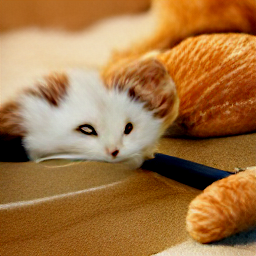

In [ ]:
images = []
for i in trange(max(n_predictions // jax.device_count(), 1)):
  # Get a new key
  key, subkey = jax.random.split(key)
  
  # Generate images
  encoded_images = p_generate(
    tokenized_prompt,
    shard_prng_key(subkey),
    params,
    gen_top_k,
    gen_top_p,
    temperature,
    cond_scale,
  )

  # Remove BOS
  encoded_images = encoded_images.sequences[..., 1:]

  # Decode images
  decoded_images = p_decode(encoded_images, vqgan_params)
  decoded_images = decoded_images.clip(0.0, 1.0).reshape((-1, 256, 256, 3))
  for decoded_img in decoded_images:
    img = Image.fromarray(np.asarray(decoded_img * 255, dtype=np.uint8))
    images.append(img)
    display(img)
    print()

In [ ]:
# !git status

On branch main
Your branch is up to date with 'origin/main'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	dalle-mini/

nothing added to commit but untracked files present (use "git add" to track)
